In [1]:
import os, joblib, json, numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import random

In [2]:
#load the saved preprocessed data

project_root = os.path.abspath(os.path.join(os.getcwd()))
processed_path = os.path.join(project_root, "Data", "Processed")

x_train = joblib.load(os.path.join(processed_path, "train_scaled.pkl"))
x_val = joblib.load(os.path.join(processed_path, "val_scaled.pkl"))
x_test = joblib.load(os.path.join(processed_path, "test_scaled.pkl"))
y_test = joblib.load(os.path.join(processed_path, "test_labels.pkl"))


x_train.shape, x_val.shape, x_test.shape

((1638568, 50), (409643, 50), (834347, 50))

In [3]:
# load scaler so that any new 
# traffic data (later) will be scaled 
# the exact same way as the trained data

scaler_path = os.path.join(processed_path, "scaler_cicids.pkl")

if os.path.exists(scaler_path):
    scaler = joblib.load(scaler_path)
else:
    scaler = None
    print("scaler not found")


In [26]:
# BUILD THE AUTOENCODER

# ensure same results every time
seed = 55
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'



input_dim = 50  # one input neuron for each feature

input_layer = Input(shape=(input_dim,), name="ae_input")   #entry point

# ENCODER (compression)
enc = Dense(32, activation='relu' , name="enc_dense_32")(input_layer)    
enc = Dense(16, activation='relu' , name="enc_dense_16")(enc)
enc = Dense(12, activation='relu' , name="enc_dense_12")(enc)
bottleneck = Dense(16, activation='relu' , name="bottleneck_16")(enc)
# each layer takes the previous layer's output and transforms it to a smaller number of neurons
# ,this compresses the information
# ,the final layer is the compressed version the encoder learns to use for reconstructing the data


# DECODER (reconstruction)
dec = Dense(12, activation='relu' , name="dec_dense_12")(bottleneck)
dec = Dense(16, activation='relu', name="dec_dense_16")(dec)
dec = Dense(32, activation='relu', name="dec_dense_32")(dec)

# these layers start reconstructing the data back to the original 50 dimension
# basically the encoder extracts patterns, decoder just rebuilds

output_layer = Dense(input_dim, activation='linear', name="ae_output")(dec)


autoencoder = Model(inputs=input_layer, outputs=output_layer, name="Autoencoder")
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

autoencoder.summary()


Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ae_input (InputLayer)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_32 (Dense)            │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_16 (Dense)            │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_12 (Dense)            │ (None, 12)             │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck_16 (Dense)           │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_12 (Dense)            │ (None, 12)             │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_16 (Dense)            │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_32 (Dense)            │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ae_output (Dense)               │ (None, 50)             │         1,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,178 (20.23 KB)

 Trainable params: 5,178 (20.23 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# TRAIN THE AUTOENCODER

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

history = autoencoder.fit(
    x_train, x_train,       # input = output bec autoencoder tries to reconstruct
    epochs=200,              # number of times the model sees all data
    batch_size=256,
    validation_data=(x_val, x_val),  #check reconstruction on validation set (no attacks)
    callbacks=[early_stop],
    verbose=1
    # shuffle=False
)


Epoch 1/200
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.1848 - val_loss: 0.0711
Epoch 2/200
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0564 - val_loss: 0.0470
Epoch 3/200
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0425 - val_loss: 0.0390
Epoch 4/200
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0365 - val_loss: 0.0345
Epoch 5/200
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0328 - val_loss: 0.0313
Epoch 6/200
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0301 - val_loss: 0.0290
Epoch 7/200
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.0279 - val_loss: 0.0270
Epoch 8/200
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0262 - val_loss: 0.0253
Epoch 9/200
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.0246 - val_loss: 0.0239
Epoch 10/200
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0233 - val_loss: 0.0228
Epoch 11/200
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0224 - val_loss: 0.0219
Epoch 12

In [28]:
# reconstruction error = how much the autoencoder failed to recreate the input

# get reconstructed outputs
train_pred = autoencoder.predict(x_train)
val_pred = autoencoder.predict(x_val)

# compute reconstruction error
train_mse = np.mean(np.square(x_train - train_pred), axis=1)
val_mse = np.mean(np.square(x_val - val_pred), axis=1)


51206/51206 ━━━━━━━━━━━━━━━━━━━━ 46s 892us/step
12802/12802 ━━━━━━━━━━━━━━━━━━━━ 11s 889us/step


In [29]:
# test on traffic with anomalies
# low error = normal behavior it understands
# high error = unusual behavior = anomaly

test_pred = autoencoder.predict(x_test)     # get reconstructed output of x+test

test_mse = np.mean(np.square(x_test - test_pred), axis=1)

train_mse[:10] , test_mse[:10]   #just to see examples

26074/26074 ━━━━━━━━━━━━━━━━━━━━ 24s 931us/step


(array([0.00028305, 0.01156217, 0.00403759, 0.00050524, 0.05502232,
        0.00724198, 0.00182937, 0.00140358, 0.03670128, 0.00114212]),
 array([0.00029553, 0.00104743, 0.00028933, 0.00024415, 0.00650014,
        0.00029178, 0.0005615 , 0.01410239, 0.00028248, 0.00462177]))

In [124]:
# set anomaly threshold 
# and decide which reconstruction errors indicate anomalies
# We want to decide which error value counts as an anomaly.


best_threshold = np.percentile(val_mse, 88)  # top % of reconstruction error

print("Best threshold:", best_threshold)
# print("Best F1:", best_f1)




Best threshold: 0.0184097715973606


In [125]:
y_pred = (test_mse > best_threshold).astype(int)
print("Number of anomalies detected:", np.sum(y_pred))
print("Actual number of anomalies:", np.sum(y_test))


Number of anomalies detected: 424583
Actual number of anomalies: 424704.0


In [126]:

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)     #how many of the detected anomalies were actually attacks
print("Recall: ", recall)           #how many actual attacks were caught
print("F1-score; ", f1)
print("Confusion matrix:\n", cm)

Accuracy:  0.8820191119522213
Precision:  0.8842205175430953
Recall:  0.8839685993068114
F1-score;  0.8840945404792491
Confusion matrix:
 [[360485  49158]
 [ 49279 375425]]


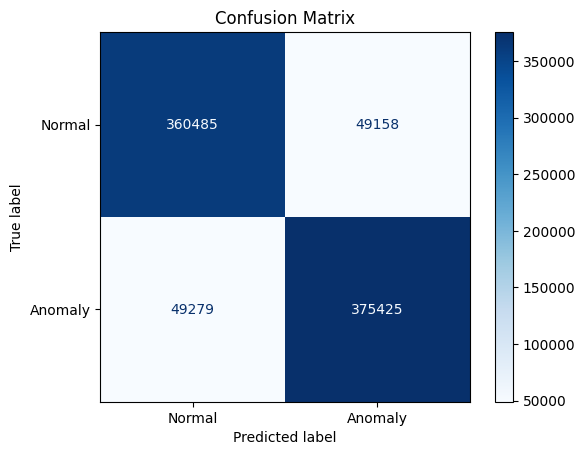

In [127]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap=plt.cm.Blues, values_format='d')  
plt.title("Confusion Matrix")
plt.show()


In [12]:
# import joblib
# import os

# project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# models_path = os.path.join(project_root, "Models")
# os.makedirs(models_path, exist_ok=True)

# joblib.dump(autoencoder, os.path.join(models_path, "autoencoder.pkl"))
# joblib.dump(best_threshold, os.path.join(models_path, "ae_threshold.pkl"))


In [128]:
import numpy as np
import joblib
import os

# project_root = r"C:/Graduation Project/AI_Cybersecurity"
# models_path = os.path.join(project_root, "Models")
# os.makedirs(models_path, exist_ok=True)

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
models_path = os.path.join(project_root, "Models")
os.makedirs(models_path, exist_ok=True)

# ----------------------------------
# 1️ Predict (Reconstruction)
# ----------------------------------
X_test_recon = autoencoder.predict(x_test, verbose=0)  # تم تعديل الاسم هنا

# ----------------------------------
# 2️ Reconstruction Error (IMPORTANT)
# ----------------------------------
recon_error = np.mean(
    np.square(x_test - X_test_recon),  # تم تعديل الاسم هنا
    axis=1
)

# ----------------------------------
# 3️ Save NumPy artifacts ONLY
# ----------------------------------
joblib.dump(
    recon_error,
    os.path.join(models_path, "ae_preds.pkl")   # numbers only
)

joblib.dump(
    best_threshold,
    os.path.join(models_path, "ae_threshold.pkl")
)

# ----------------------------------
# 4️ Save model separately 
# ----------------------------------
autoencoder.save(
    os.path.join(models_path, "autoencoder.keras")
)


# Predict reconstructed outputs
# -------------------------------
train_pred = autoencoder.predict(x_train, verbose=0)
val_pred   = autoencoder.predict(x_val, verbose=0)

# -------------------------------
# Compute reconstruction error
# -------------------------------
train_mse = np.mean(np.square(x_train - train_pred), axis=1)
val_mse   = np.mean(np.square(x_val - val_pred), axis=1)

# -------------------------------
# Save reconstruction errors
# -------------------------------
joblib.dump(train_mse, os.path.join(models_path, "ae_train_scores.pkl"))
joblib.dump(val_mse, os.path.join(models_path, "ae_val_scores.pkl"))

['c:\\Graduation Project\\Models\\ae_val_scores.pkl']